In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wine-quality/winequalityN.csv


# Importing the dataset

In [2]:
wine = pd.read_csv("/kaggle/input/wine-quality/winequalityN.csv")
wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Preprocessing

Let's have a look at the features and their data types

In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Check to see if have any null values and duplicate values and drop those observations.

In [4]:
print(wine.isnull().sum())
wine = wine.dropna()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


In [5]:
print(wine.duplicated().sum())
wine.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
wine.shape

1168


(5295, 13)

# Exploratory Data Analysis

Let's get an idea of how many samples we have of each type, red and white

In [6]:
wine['type'].value_counts(normalize=False)

white    3942
red      1353
Name: type, dtype: int64

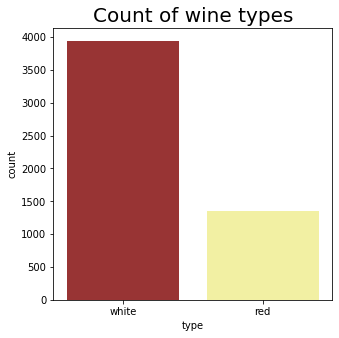

In [7]:
plt.figure(figsize = (5,5))
sns.countplot(x = wine['type'], palette=["#a92323", '#FFFC96']);
plt.title("Count of wine types", size=20, color="black")
plt.xlabels =["Red", "White"]

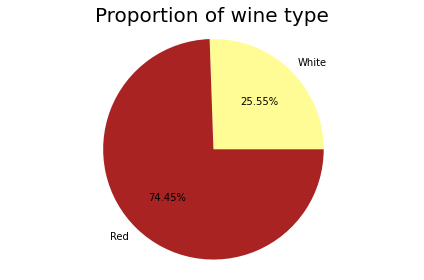

In [8]:
labels =["White", "Red"]
sizes = [wine['type'].value_counts()[1], wine['type'].value_counts()[0]]
colors = ['#FFFC96','#a92323']
fig1, ax1 = plt.subplots()
ax1.pie(x = sizes, labels = labels, colors = colors, autopct='%1.2f%%')
plt.title("Proportion of wine type", size=20, color="black")
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Transform the categorical variable 'type' by encoding the labels

In [9]:
encoder = LabelEncoder()
encoder.fit(wine['type'])
wine['type'] = encoder.transform(wine['type'])
wine['type']

0       1
1       1
2       1
3       1
6       1
       ..
6490    0
6491    0
6492    0
6495    0
6496    0
Name: type, Length: 5295, dtype: int64

Looking into the relationship between eacch pair of feature variables

In [10]:
correlation = wine.corr()

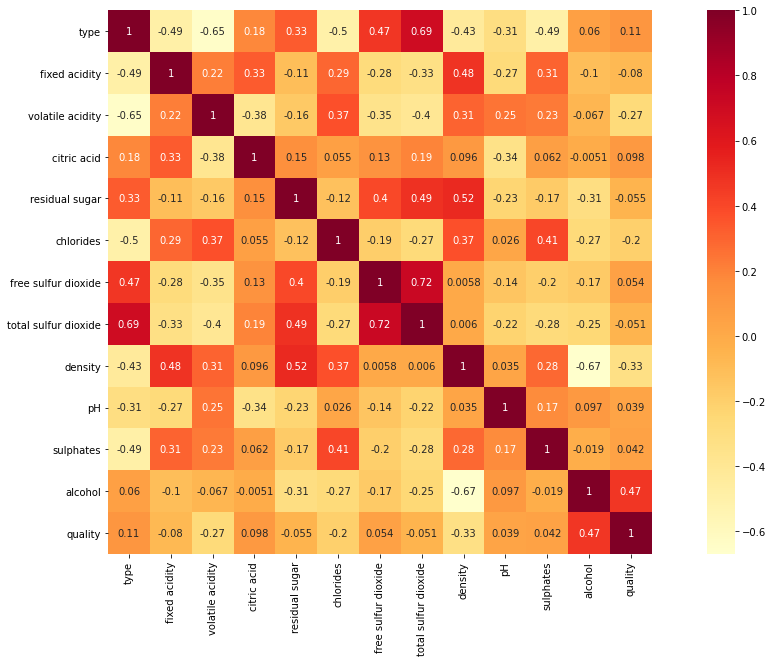

In [11]:
plt.figure(figsize=(20, 10))
sns.heatmap(wine.corr(), square=True, annot=True, cmap="YlOrRd");

The variable of interest here is the 'type' variable. Clearly certain variables are more strongly correlated to the wine type than others, like total sulfur dioxide, free sulfur dioxide, volatile acidity and residual sugar 

In [12]:
wine.groupby('type')['total sulfur dioxide'].mean().to_frame(name = 'mean').reset_index()

,type,mean
0,0,46.822986
1,1,137.215753


<AxesSubplot:xlabel='type'>

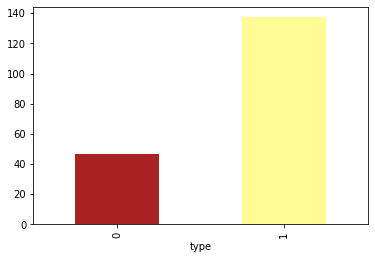

In [13]:
wine.groupby('type')['total sulfur dioxide'].mean().plot.bar(x='type', y='mean', color=["#a92323", "#FFFC96"])

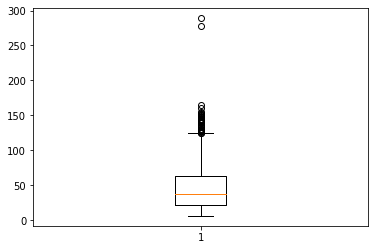

In [14]:
boxdata = wine[wine['type']==0]
boxdata = boxdata [['total sulfur dioxide']]

plt.boxplot(boxdata, notch=None)
plt.show()

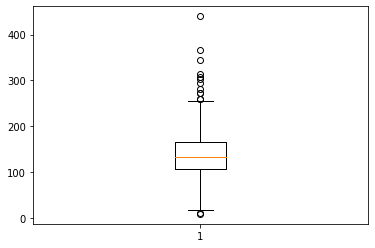

In [15]:
boxdata2 = wine[wine['type']==1]
boxdata2 = boxdata2 [['total sulfur dioxide']]

plt.boxplot(boxdata2, notch=None)
plt.show()

<AxesSubplot:xlabel='type'>

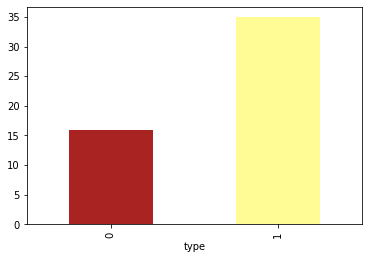

In [16]:
wine.groupby('type')['free sulfur dioxide'].mean().plot.bar(x='type', y='mean',color=["#a92323", "#FFFC96"])

<AxesSubplot:xlabel='type'>

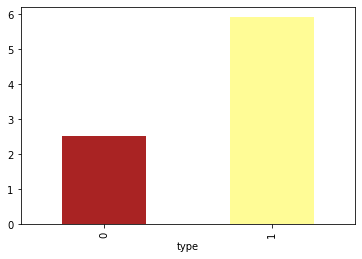

In [17]:
wine.groupby('type')['residual sugar'].mean().plot.bar(x='type', y='mean',color=["#a92323", "#FFFC96"])

<AxesSubplot:xlabel='type'>

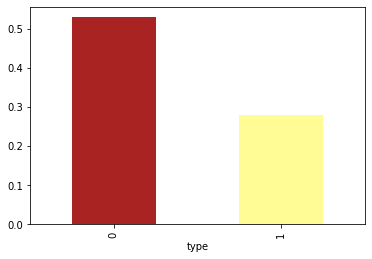

In [18]:
wine.groupby('type')['volatile acidity'].mean().plot.bar(x='type', y='mean',color=["#a92323", "#FFFC96"])

<AxesSubplot:xlabel='type'>

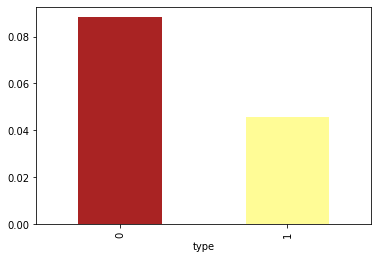

In [19]:
wine.groupby('type')['chlorides'].mean().plot.bar(x='type', y='mean',color=["#a92323", "#FFFC96"])

# Scaling the features

In [20]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates']
scaler = StandardScaler()
df = wine
df[features] = scaler.fit_transform(df[features])
df.head(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,-0.165087,-0.440021,0.280208,3.477382,-0.316815,0.838865,0.984149,2.177419,-1.401186,-0.555267,8.8,6
1,1,-0.695163,-0.261684,0.144245,-0.766859,-0.208407,-0.900220,0.314921,-0.180598,0.472180,-0.288309,9.5,6
2,1,0.667890,-0.380575,0.552136,0.410863,-0.181305,-0.002628,-0.301474,0.189947,0.222398,-0.622007,10.1,6


# Splitting the data 

In [21]:
target = df['type']
data = df.drop(['type'], axis = 1)

x_train,x_test,y_train,y_test = train_test_split(data,target,train_size =0.8, test_size=0.2,random_state=11)

In [22]:
x_train.shape

(4236, 12)

In [23]:
y_train.shape


(4236,)

In [24]:
x_test.shape

(1059, 12)

# Dummy Classifier
Building a baseline model for comparasion purposes

In [25]:
DummyC = DummyClassifier(strategy='stratified', random_state =0)
DummyC.fit(x_train,y_train)
DummyC

DummyClassifier(random_state=0, strategy='stratified')

In [26]:
Dummy_pred = DummyC.predict(x_test)

<h3>Evaluation Metrics</h3> 

In [27]:
print(classification_report(y_test,Dummy_pred))

              precision    recall  f1-score   support

           0       0.22      0.20      0.21       276
           1       0.73      0.74      0.74       783

    accuracy                           0.60      1059
   macro avg       0.47      0.47      0.47      1059
weighted avg       0.59      0.60      0.60      1059



Text(33.0, 0.5, 'Actual')

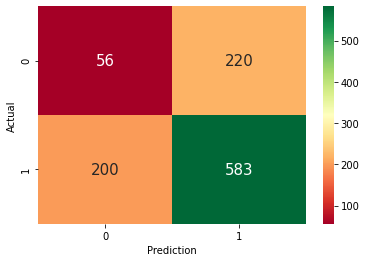

In [28]:
confusion = confusion_matrix(y_test,Dummy_pred)
sns.heatmap(confusion,annot=True,annot_kws = {'size':15},fmt=".0f", cmap="RdYlGn")
plt.xlabel("Prediction")
plt.ylabel("Actual")

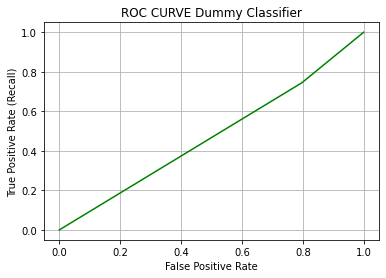

The score for the ROC Curve is: 47.4%


In [29]:
fpr, tpr, thresholds = roc_curve(y_test,Dummy_pred)
auc = roc_auc_score(y_test, Dummy_pred)
plt.plot(fpr, tpr, color='g')
plt.title('ROC CURVE Dummy Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

dummy_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

# K Neighbours Classifier

In [30]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)


<h3>Evaluation Metrics</h3> 

In [31]:
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       276
           1       0.99      1.00      0.99       783

    accuracy                           0.99      1059
   macro avg       0.99      0.98      0.99      1059
weighted avg       0.99      0.99      0.99      1059



Text(33.0, 0.5, 'Actual')

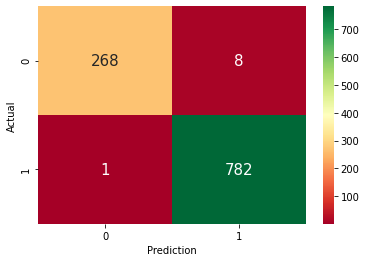

In [32]:
confusion = confusion_matrix(y_test,knn_pred)
sns.heatmap(confusion,annot=True,annot_kws = {'size':15},fmt=".0f", cmap="RdYlGn")
plt.xlabel("Prediction")
plt.ylabel("Actual")

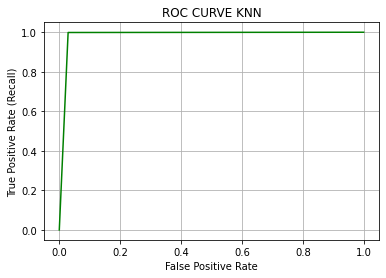

The score for the ROC Curve is: 98.5%


In [33]:
fpr, tpr, thresholds = roc_curve(y_test,knn_pred)
auc = roc_auc_score(y_test, knn_pred)
plt.plot(fpr, tpr, color='g')
plt.title('ROC CURVE KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

dummy_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

In [34]:
k_range = list(range(3,20)) # we will test k values in range 3-50
weight_op = ['uniform', 'distance'] # we will test the knn methods uniform & distance
d = {'n_neighbors' :k_range, 'weights': weight_op}

<h3>Hyperparameter Tuning using GridSearchCV</h3> 

In [35]:
grid_temp = GridSearchCV(knn, d, cv=10, scoring='accuracy') # we chose model, d(range, methods), num of cv groups and scoring method
grid_temp.fit(data, target)
print("Score:",grid_temp.best_score_," Parameters:",grid_temp.best_params_)

Score: 0.9933883796411884  Parameters: {'n_neighbors': 6, 'weights': 'distance'}


In [36]:
knn = KNeighborsClassifier(n_neighbors = 6, weights = 'distance')
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)

<h3>Evaluation Metrics</h3> 

Text(33.0, 0.5, 'Actual')

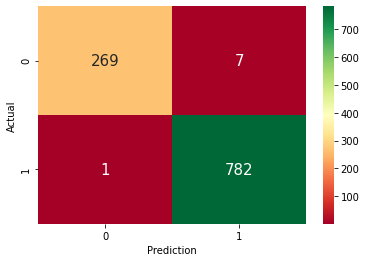

In [37]:
confusion = confusion_matrix(y_test,knn_pred)
sns.heatmap(confusion,annot=True,annot_kws = {'size':15},fmt=".0f", cmap="RdYlGn")
plt.xlabel("Prediction")
plt.ylabel("Actual")

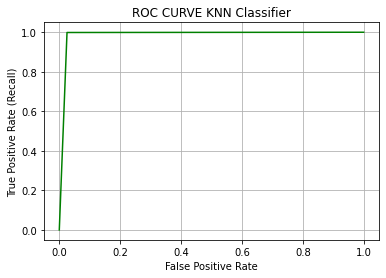

The score for the ROC Curve is: 98.7%


In [38]:
fpr, tpr, thresholds = roc_curve(y_test,knn_pred)
auc = roc_auc_score(y_test, knn_pred)
plt.plot(fpr, tpr, color='g')
plt.title('ROC CURVE KNN Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

knn_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

<h3>Radius Neighbors Classifier</h3>

In [39]:
from sklearn.neighbors import RadiusNeighborsClassifier
rad = RadiusNeighborsClassifier(radius = 4, outlier_label = 'most_frequent')
rad.fit(x_train,y_train)

RadiusNeighborsClassifier(outlier_label='most_frequent', radius=4)

<h3>Evaluation Metrics</h3> 

In [ ]:
rad_pred = rad.predict(x_test)
print(classification_report(y_test,rad_pred))

In [ ]:
confusion = confusion_matrix(y_test,rad_pred)
sns.heatmap(confusion,annot=True,annot_kws = {'size':15},fmt=".0f", cmap="RdYlGn")
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [ ]:
radius_range = list(range(1,10)) # we will test k values in range 3-50
weight_op = ['uniform', 'distance'] # we will test the knn methods uniform & distance
d = {'radius' :radius_range, 'weights': weight_op}

In [ ]:
grid_temp = GridSearchCV(rad, d, cv=10, scoring='accuracy') # we chose model, d(range, methods), num of cv groups and scoring method
grid_temp.fit(data, target)
print("Score:",grid_temp.best_score_," Parameters:",grid_temp.best_params_)

In [ ]:
rad = RadiusNeighborsClassifier(radius=3, weights='distance', outlier_label='most_frequent')
rad.fit(x_train,y_train)
rad2_pred = rad.predict(x_test)

<h3>Evaluation Metrics</h3> 

In [ ]:
print(classification_report(y_test,rad2_pred))

In [ ]:
confusion = confusion_matrix(y_test,rad2_pred)
sns.heatmap(confusion,annot=True,annot_kws = {'size':15},fmt=".0f", cmap="RdYlGn")
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,rad2_pred)
auc = roc_auc_score(y_test, rad2_pred)
plt.plot(fpr, tpr, color='g')
plt.title('ROC CURVE RNN Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

rad_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)


In [ ]:
log_pred = logreg.predict(x_test)
print(classification_report(y_test, log_pred))

In [ ]:
confusion = confusion_matrix(y_test,log_pred)
sns.heatmap(confusion,annot=True,annot_kws = {'size':15},fmt=".0f", cmap="RdYlGn")
plt.xlabel("Prediction")
plt.ylabel("Actual")

<h3>Evaluation Metrics</h3> 

In [ ]:
cm = confusion_matrix(y_test, log_pred)
sns.heatmap(cm, annot=True, annot_kws = {'size':15},fmt=".0f", cmap="RdYlGn")
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
print(metrics.accuracy_score(y_test, log_pred))

In [ ]:
fpr, tpr, _= roc_curve(y_test, log_pred)
auc= roc_auc_score(y_test, log_pred)
plt.plot(fpr, tpr, label="auc="+str(auc), color='orange')
plt.box(False)
plt.title('ROC CURVE Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

lr_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

In [ ]:
print("The score for the models:\n")
print("Dummy Classifer:                  ",dummy_auc,"%")
print("KNN:                              ",knn_auc,"%")
print("Radius Nearest Neighbours:        ",rad_auc,"%")
print("Logistic Regression:              ",lr_auc,"%")

# KNN is the most accurate model for our dataset, with an AUC Score of 98.7%.